# Set up 

In [ ]:
import os
import random
import json
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [ ]:
# authorize access to google drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# navigate to gdrive home directory
%cd gdrive/MyDrive


/content/gdrive/MyDrive


In [ ]:
# set paths
DIR_DATA_ORIGINAL = 'projet_radio_covid/COVID-19_Radiography_Dataset/'  # set to local path
DIR_DATA = 'projet_radio_covid/data/'  

LST_GROUP = ['covid', 'normal', 'viral', 'opac']
LST_FOLDERS = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
FNAME_MAPPER = dict(zip(LST_GROUP, LST_FOLDERS))
LABEL_MAPPER = dict(zip(LST_GROUP, range(4)))

DIRS = dict(zip(LST_GROUP, [os.path.join(DIR_DATA_ORIGINAL, folder) for folder in LST_FOLDERS]))
DIR_IMAGES = dict(zip(LST_GROUP, [os.path.join(dir, 'images') for dir in DIRS.values()]))
DIR_MASKS = dict(zip(LST_GROUP, [os.path.join(dir, 'masks') for dir in DIRS.values()]))

NUM_ALL_IMG = [3616,10192,1345,6012]

# Utils

## Data Preprocessing utils

In [ ]:
# utils 

def get_fname(group, idx):
  return(f"{FNAME_MAPPER[group]}-{idx}.png")

def crop_black_border(image):
  assert image.shape[0] == image.shape[1]
  old_dim = image.shape[0]

  mask = image!=0
  mask_row = mask.any(0)
  mask_col = mask.any(1)

  row_range = old_dim - mask_row.argmax() - mask_row[::-1].argmax()
  col_range = old_dim - mask_col.argmax() - mask_col[::-1].argmax() 

  if row_range < col_range:
    top = mask_col.argmax()
    bottom = old_dim - mask_col[::-1].argmax()
    left = mask_row.argmax() - (col_range - row_range)//2
    right = old_dim - mask_row[::-1].argmax() + (col_range - row_range)//2
    if left < 0:
      left, right = 0, col_range
    elif right > old_dim:
      left, right = old_dim - col_range, col_range
  else:
    left = mask_row.argmax()
    right = old_dim - mask_row[::-1].argmax()
    top = mask_col.argmax() - (row_range - col_range)//2
    bottom = old_dim - mask_col[::-1].argmax() + (row_range - col_range)//2
    if top < 0:
      top, bottom = 0, row_range
    elif bottom > old_dim:
      top, bottom = old_dim - row_range, old_dim
  return image[top:bottom, left:right]


def normalize_intensity(img, mean=.2, min=0):
  return(img/img.mean() * (mean - min) + min)
  

def get_str_param(dict_params):
    """
    Transform a dictionary of parameters into a single string.
    :param dict_params: dict: parameters of a function
    :return: str: string of the parameters' name and value
    """
    str_param = ''
    if dict_params is None:
      return "default"
    else: 
      for key, value in dict_params.items():
          if type(value) in [list, tuple]:  # convert list or tuple to str, using "_" to connect the elements
              str_param += '_' + key + '_' + "_".join([str(v) for v in value]) if len(value) > 1 else value
          else:
              str_param += ('_' + key + '_' + str(value))
      str_param = str_param.replace('True', 't')  # to make the string shorter: True -> t, False -> f
      str_param = str_param.replace('False', 'f')
      str_param = str_param.replace('.', 'd')  # replace dot of decimal by "d"
      str_param = str_param.replace('e-', 'e')  # remove '-' in scientific notation e.g. 5.3e-3
      str_param = str_param.replace(' ', '')
      return str_param[1:].lower()

In [ ]:
# preprocessing pipeline
def pipeline_reverse_mask(groups=list, num_images=list, image_size=(50, 50), use_mask=True, 
             crop=False, flatten=False, normalize=False, path_output=None, **kwargs):
  """
  Parameters
  ------------
  groups: list of categories (labels) of input data
  num_images: list of number of images in each group. pass NUM_ALL_IMG to use all the images in current dataset.
  image_size: tuple: the destinated size of each image. If none, the image will be 256*256. 
  use_mask: bool: whether apply the masks to the radio images.
  crop: bool: whether crop the black border after applying mask. 
  flatten: bool: return the images as matrix if False; else, return flattened vectors.

  Return:
  ------------
  X, y

  """
  X = np.zeros((sum(num_images), 256, 256))
  y = np.zeros(sum(num_images))
  sum_num = 0

  # load the images
  print('image loading ...')
  for group, num in zip(groups, num_images):
    X[sum_num:(sum_num + num), :, :] = [resize(imread(os.path.join(DIR_IMAGES[group], get_fname(group, idx)), as_gray=True), (256, 256), anti_aliasing=True) 
    for idx in range(1, num + 1)]
    y[sum_num:sum_num + num] = [LABEL_MAPPER[group]] * num
    sum_num += num

  # masking
  if use_mask== "reversed":
    print('mask loading ...')
    masks = np.zeros((sum(num_images), 256, 256))
    sum_num = 0
    for group, num in zip(groups, num_images):
      masks[sum_num:(sum_num + num), :, :] = [imread(os.path.join(DIR_MASKS[group], get_fname(group, idx)), as_gray=True)
      for idx in range(1, num + 1)]
      sum_num += num
    X = X * (1- masks)
  else:
    raise ValueError('this pipeline is only for reversed mask')
    
  # crop the black border and resize
  if crop:
    print('border cropping ...')
    X = np.array([resize(crop_black_border(image), image_size, anti_aliasing=True) for image in X])
  else: 
    print('resizing ...')
    X = resize(X, (X.shape[0], *image_size), anti_aliasing=True)

  # normalize intensity
  if normalize:
    min_intensity = kwargs.get('min', 0)
    mean_intensity = kwargs.get('mean', .2)
    X = normalize_intensity(X, mean=mean_intensity, min=min_intensity)  # todo use min_max as option

  if not flatten:
    if path_output is not None:
      for i, path in enumerate(path_output):
        plt.imsave(path, X[i], cmap='gray')
    else:
      return X, y
  else:
    # reshape each image to 1-D vector
    X = X.reshape(X.shape[0], -1)
    if path_output is not None:
      for i, path in enumerate(path_output):
        with open(path, 'w') as fo:
          json.dump(X[i].tolist(), fo)
    else:
      return X, y


## Model training utils

In [ ]:
# set paths
DIR_OUTPUT = "projet_radio_covid/results/"

def get_dir_pred(clf_name):
  dir_pred = os.path.join(DIR_OUTPUT, 'pred_' + clf_name)
  if not os.path.exists(dir_pred):
    os.mkdir(dir_pred)
    print(dir_pred, "folder created")
  return dir_pred

def get_path_metric(clf_name):
  return os.path.join(DIR_OUTPUT, 'metrics_'+ clf_name + '.json')



In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report


def save_pred(y_test, y_pred, clf_name, preprocess_params, clf_params):
  """
  save the prediction results to google drive
  """
  dir_pred = get_dir_pred(clf_name)
  if not os.path.exists(os.path.join(dir_pred, get_str_param(preprocess_params))):
    os.mkdir(os.path.join(dir_pred, get_str_param(preprocess_params)))
  
  pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).to_csv(
      os.path.join(dir_pred, get_str_param(preprocess_params), get_str_param(clf_params) + '.txt'),
      sep='\t', header=True, index=False)
  return None



def get_metrics(y_test, y_pred, clf_params, preprocess_params):
    """
    Get the metrics of interests and return them in a dictionary.
    :param y_test: True values of the labels of the test set
    :param y_pred: predicted labels of the test set
    :param clf_params: dict: parameters of the classifier
    :param preprocess_params: dict: parameters of the preprocessing
    :return: evaluation metrics as a dictionary
    """
    # Calculate the evaluation metrics
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_matrix_array = confusion_matrix(y_test, y_pred)

    # Store the metrics in a dictionary
    results = {
        'preprocess_params': get_str_param(preprocess_params),
        "clf_params": get_str_param(clf_params),
        "precision": precision.tolist(),
        "recall": recall.tolist(),
        "f1": f1.tolist(),
        "accuracy": accuracy.tolist(),
        "confusion_matrix": confusion_matrix_array.tolist()
    }
    
    return results


def save_metrics(y_test, y_pred, clf_name, preprocess_params, clf_params=None):
  """
  get and save the metrics in google drive
  """
  path_metric = get_path_metric(clf_name)
  new_result = get_metrics(y_pred, y_test, clf_params, preprocess_params)

  if not os.path.exists(path_metric):
      print("new file", path_metric, "created")
      with open(path_metric, 'w') as fo:
          json.dump({}, fo)

  try:
    with open(path_metric, 'r') as fi:
        all_results = json.load(fi)
  except:
    all_results = {} 

  if all_results is None:
    all_results = {}
    
  all_results.update({len(all_results): new_result})

  with open(path_metric, 'w') as fo:
      json.dump(all_results, fo)


In [ ]:
def load_summary_metrics(lst_clf_names, dct_clf_params, str_preprocess_param):
  recall_covid = []
  recall_sick = []
  precision_normal = []
  precision_non_covid = []
  mean_recall = []
  mean_precision = []
  mean_f1 = []
  accuracy = []

  for clf_name in lst_clf_names:
    try:
      with open(get_path_metric(clf_name), 'r') as fi:
        all_metrics = json.load(fi)
    except:
      print(clf_name, "results are missing")

    metric = [value for key, value in all_metrics.items() if (value['preprocess_params'] == str_preprocess_param) and (value['clf_params'] == dct_clf_params[clf_name])]
    if len(metric) == 0:
      print(clf_name, "results are missing for given parameters")
      break
    else:
      metric = metric[-1]
    
    recall_covid.append(metric['recall'][0])
    recall_sick.append((metric['recall'][0]+ sum(metric['recall'][2:])) /3)
    precision_non_covid.append(np.mean(metric['precision'][1:]))
    precision_normal.append(metric['precision'][1])
    mean_recall.append(np.mean(metric['recall']))
    mean_precision.append(np.mean(metric['precision']))
    mean_f1.append(np.mean(metric['f1']))
    accuracy.append(metric['accuracy'])           

  df_summary_metric = pd.DataFrame({
      "recall_covid": recall_covid,
      'recall_sick': recall_sick,
      "precision_non_covid": precision_non_covid,
      "precision_normal": precision_normal,
      "mean_recall": mean_recall,
      "mean_precision": mean_precision,
      'mean_f1': mean_f1,
      "accuracy": accuracy
  }).T.round(2)
  df_summary_metric.columns = lst_clf_names
  return df_summary_metric


# model training


## Baseline models

### Training

In [ ]:
# read and preprocess the images

# images with masks
baseline_prepro_params = {
    'frac': 4,
    'image_size': (128, 128),
    'mask': 'reversed', 
    'crop': False,
    'flatten': True,
    'normalize': False,
    'pca': 0.9
}

# # images without masks
# baseline_prepro_params = {
#     'frac': 4,
#     'image_size': (128, 128),
#     'mask': False, 
#     'crop': False,
#     'flatten': True,
#     'normalize': False,
#     'pca': 0.9
# }

In [ ]:
# load and preprocess data by pipeline
t0 = time.time()
X, y = pipeline_reverse_mask(
    groups=LST_GROUP, 
    num_images=np.array(NUM_ALL_IMG) // baseline_prepro_params['frac'],   # pass NUM_ALL_IMG to use all the images.
    image_size=baseline_prepro_params['image_size'],
    use_mask=baseline_prepro_params['mask'],
    crop=baseline_prepro_params['crop'], 
    flatten=baseline_prepro_params['flatten'],
    normalize=baseline_prepro_params['normalize']
    )
print("loading and preprocessing time", round(time.time() - t0), 's, i.e.', round((time.time() - t0)/60), 'min')


image loading ...
mask loading ...
border cropping ...
loading and preprocessing time 2649 s, i.e. 44 min


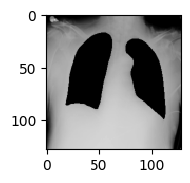

In [ ]:
plt.figure(figsize=(2, 2))
imshow(X[0].reshape(128, 128));

In [ ]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, shuffle=True, stratify=y)

In [ ]:
# pca 
if baseline_prepro_params['pca'] is not None: 
  t0 = time.time()
  pca = PCA(n_components = baseline_prepro_params['pca'])  
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  print("pca time", round(time.time() - t0), 's, i.e.', round((time.time() - t0)/60), 'min')


pca time 99 s, i.e. 2 min


In [ ]:
# Logistic Regression

clf_name = "lr"

from sklearn.linear_model import LogisticRegression

lr_params = {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0, 'max_iter': 2000}

logreg = LogisticRegression()
logreg.set_params(**lr_params)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
save_pred(y_test, y_pred, clf_name, baseline_prepro_params, clf_params=lr_params)
save_metrics(y_test, y_pred, clf_name, baseline_prepro_params, clf_params=lr_params)

In [ ]:
# SVM
clf_name = 'svm'
from sklearn.svm import SVC

svc_params = {"C": 10, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}

svc = SVC()    #C=1 par défaut, kernel=rbf' par défaut, gamma='scale' par défaut (sauf pour linear)
svc.set_params(**svc_params)
svc.fit(X_train, y_train)
y_pred=svc.predict(X_test)

clf_params = {'kernel': 'linear'}
save_pred(y_test, y_pred, clf_name, baseline_prepro_params, clf_params=svc_params)
save_metrics(y_test, y_pred, clf_name, baseline_prepro_params, clf_params=svc_params)


In [ ]:
# random forest
clf_name = "rf"

from sklearn import ensemble
rf_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
rf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=23)
rf.set_params(**rf_params)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

save_pred(y_test, y_pred, clf_name, baseline_prepro_params, clf_params=rf_params)
save_metrics(y_test, y_pred, clf_name, baseline_prepro_params, clf_params=rf_params)


In [ ]:
# Gradient Boosting

clf_name = "gb"

gb = ensemble.GradientBoostingClassifier()
gb_params =  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
gb.set_params(**gb_params)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

save_pred(y_test, y_pred, clf_name, baseline_prepro_params, clf_params=gb_params)
save_metrics(y_test, y_pred, clf_name, baseline_prepro_params, clf_params=gb_params)


In [ ]:
lr_params = {'multi_class': 'multinomial', 'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0, 'max_iter': 2000}
svc_params = {"C": 10, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced'}
rf_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
gb_params =  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

# load the results
lst_clf_names = ["lr", "svm", "rf", "gb"]
dct_clf_params = {
    "lr": get_str_param(lr_params),
    "svm": get_str_param(svc_params),  
    "rf": get_str_param(rf_params),
    "gb": get_str_param(gb_params), 
}

df_metric_baseline_reversed_mask = load_summary_metrics(lst_clf_names, dct_clf_params, "frac_4_image_size_128_128_mask_reversed_crop_t_flatten_t_normalize_f_pca_0d9")

# todo crop should be false 



### Results

In [ ]:
df_metric_baseline_reversed_mask

,lr,svm,rf,gb
recall_covid,0.66,0.73,0.87,0.76
recall_sick,0.66,0.79,0.82,0.78
precision_non_covid,0.75,0.82,0.60,0.70
precision_normal,0.78,0.84,0.87,0.83
mean_recall,0.69,0.81,0.79,0.79
mean_precision,0.69,0.80,0.57,0.68
mean_f1,0.69,0.80,0.61,0.72
accuracy,0.71,0.81,0.71,0.76


Text(0.5, 1.0, 'Evaluation of model prediction using images without lung zone (reversed mask)')

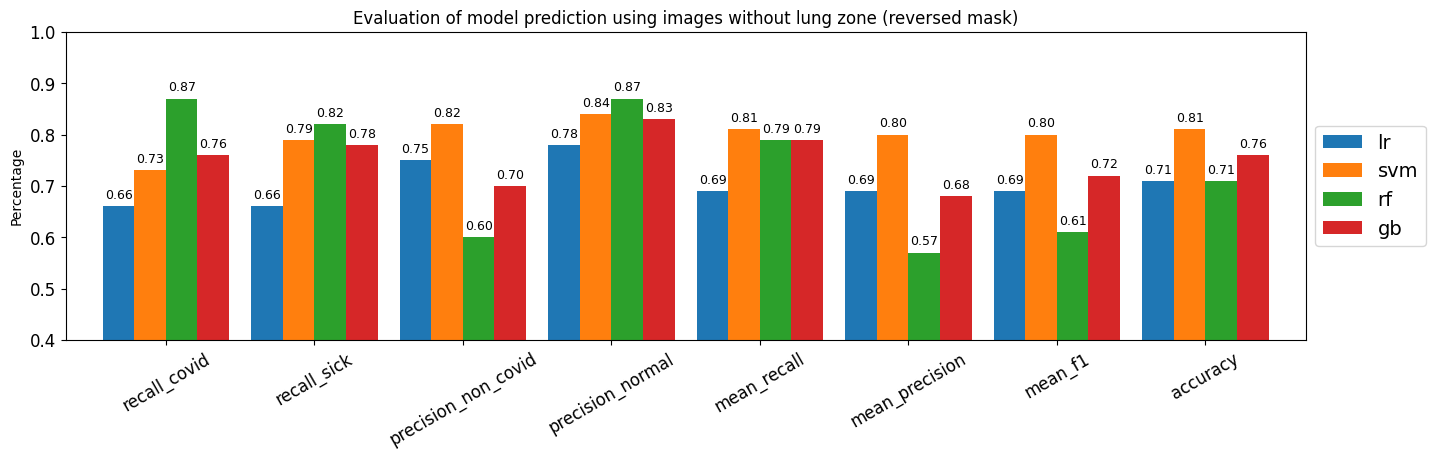

In [ ]:
## graph format version Isa

import matplotlib.ticker as mticker
label_format = '{:,.0%}'
ax1 = df_metric_baseline_reversed_mask.plot.bar(figsize=(16, 4), ylabel='Percentage', width=0.85, align = 'center')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():0.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha = 'center', va = 'center', 
                 xytext = (0, 8), 
                 textcoords = 'offset points', 
                 fontsize=9)
ax1.tick_params(axis='x', labelsize=12, rotation=30)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylim(0.4,1.0)
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=14)
ax1.set_title('Evaluation of model prediction using images without lung zone (reversed mask)')
